In [72]:
!pip install torchmetrics -q

In [73]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
from sklearn.metrics import classification_report

In [74]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

In [75]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.15, random_state=42)

In [76]:
import numpy as np
print(np.unique(Y))

[0 1 2]


In [77]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [78]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.len = self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [79]:
train_dataset = Data(x_train, y_train)
trainloader = DataLoader(dataset=train_dataset,batch_size=64)
val_dataset = Data(x_train, y_train)
val_loader = DataLoader(dataset=val_dataset,batch_size=64)
test_dataset = Data(x_train, y_train)
test_loader = DataLoader(dataset=test_dataset,batch_size=64)

In [80]:
for x,y in trainloader:
    print(x.shape, y)

torch.Size([64, 4]) tensor([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2,
        1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1, 0, 0,
        2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2])
torch.Size([36, 4]) tensor([0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2,
        1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])


In [81]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [82]:
input_dim = 4
hidden_dim = 25
output_dim = 3
model = Net(input_dim,hidden_dim,output_dim)

Viết đoạn scrip để train và Inference
- trong phần code train phải log ra được loss, Accuracy, Precision, Recall, F1
- Xuất ra classification_report bằng sklearn trong phần Inference

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
model = Net(input_dim,hidden_dim,output_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [85]:

accuracy = Accuracy(task='multiclass', num_classes=3)
precision = Precision(task='multiclass', average='macro', num_classes=3)
recall = Recall(task='multiclass', average='macro', num_classes=3)
f1 = F1Score(task='multiclass', average='macro', num_classes=3)

In [86]:
num_epochs = 100

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# Training and Validation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for x, y in tqdm(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Training Metrics
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)
    train_acc = accuracy(all_preds, all_labels)
    train_precision = precision(all_preds, all_labels)
    train_recall = recall(all_preds, all_labels)
    train_f1 = f1(all_preds, all_labels)
    avg_train_loss = total_loss / len(trainloader)

    train_acc_list.append(train_acc)
    train_loss_list.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Train Acc: {train_acc:.4f} - "
          f"Train Precision: {train_precision:.4f} - "
          f"Train Recall: {train_recall:.4f} - "
          f"Train F1: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_total_loss = 0
    val_all_preds, val_all_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss = loss_fn(y_pred, y)

            val_total_loss += val_loss.item()
            val_all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
            val_all_labels.extend(y.cpu().numpy())

    # Validation Metrics
    val_all_preds = torch.tensor(val_all_preds)
    val_all_labels = torch.tensor(val_all_labels)
    val_acc = accuracy(val_all_preds, val_all_labels)
    val_precision = precision(val_all_preds, val_all_labels)
    val_recall = recall(val_all_preds, val_all_labels)
    val_f1 = f1(val_all_preds, val_all_labels)
    avg_val_loss = val_total_loss / len(val_loader)

    val_acc_list.append(val_acc)
    val_loss_list.append(avg_val_loss)

    # Save weight model for each epochs:
    torch.save(model.state_dict(), f'weights_epoch_{epoch+1}.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Val Loss: {avg_val_loss:.4f} - "
          f"Val Acc: {val_acc:.4f} - "
          f"Val Precision: {val_precision:.4f} - "
          f"Val Recall: {val_recall:.4f} - "
          f"Val F1: {val_f1:.4f}")


100%|██████████| 2/2 [00:00<00:00, 78.72it/s]


Epoch [1/100] - Train Loss: 1.1460 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [1/100] - Val Loss: 1.1398 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 146.37it/s]


Epoch [2/100] - Train Loss: 1.1381 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [2/100] - Val Loss: 1.1326 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 176.35it/s]


Epoch [3/100] - Train Loss: 1.1310 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [3/100] - Val Loss: 1.1260 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 112.84it/s]


Epoch [4/100] - Train Loss: 1.1245 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [4/100] - Val Loss: 1.1200 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 130.05it/s]


Epoch [5/100] - Train Loss: 1.1185 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [5/100] - Val Loss: 1.1144 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 117.70it/s]


Epoch [6/100] - Train Loss: 1.1131 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [6/100] - Val Loss: 1.1094 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 133.54it/s]


Epoch [7/100] - Train Loss: 1.1082 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [7/100] - Val Loss: 1.1048 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 63.44it/s]


Epoch [8/100] - Train Loss: 1.1037 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [8/100] - Val Loss: 1.1007 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 104.45it/s]


Epoch [9/100] - Train Loss: 1.0997 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [9/100] - Val Loss: 1.0969 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 148.19it/s]


Epoch [10/100] - Train Loss: 1.0960 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [10/100] - Val Loss: 1.0934 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 124.40it/s]


Epoch [11/100] - Train Loss: 1.0926 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [11/100] - Val Loss: 1.0902 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 112.56it/s]

Epoch [12/100] - Train Loss: 1.0895 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692


Epoch [12/100] - Val Loss: 1.0873 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]


Epoch [13/100] - Train Loss: 1.0865 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [13/100] - Val Loss: 1.0844 - Val Acc: 0.3400 - Val Precision: 0.1133 - Val Recall: 0.3333 - Val F1: 0.1692


100%|██████████| 2/2 [00:00<00:00, 203.57it/s]


Epoch [14/100] - Train Loss: 1.0838 - Train Acc: 0.3400 - Train Precision: 0.1145 - Train Recall: 0.3333 - Train F1: 0.1704
Epoch [14/100] - Val Loss: 1.0817 - Val Acc: 0.3800 - Val Precision: 0.3860 - Val Recall: 0.3714 - Val F1: 0.2424


100%|██████████| 2/2 [00:00<00:00, 108.69it/s]


Epoch [15/100] - Train Loss: 1.0811 - Train Acc: 0.3900 - Train Precision: 0.3431 - Train Recall: 0.3807 - Train F1: 0.2669
Epoch [15/100] - Val Loss: 1.0790 - Val Acc: 0.4400 - Val Precision: 0.2960 - Val Recall: 0.4269 - Val F1: 0.3409


100%|██████████| 2/2 [00:00<00:00, 267.51it/s]


Epoch [16/100] - Train Loss: 1.0784 - Train Acc: 0.4800 - Train Precision: 0.3222 - Train Recall: 0.4650 - Train F1: 0.3764
Epoch [16/100] - Val Loss: 1.0764 - Val Acc: 0.5300 - Val Precision: 0.4598 - Val Recall: 0.5098 - Val F1: 0.4276


100%|██████████| 2/2 [00:00<00:00, 276.83it/s]


Epoch [17/100] - Train Loss: 1.0758 - Train Acc: 0.5000 - Train Precision: 0.4514 - Train Recall: 0.4804 - Train F1: 0.3961
Epoch [17/100] - Val Loss: 1.0738 - Val Acc: 0.4100 - Val Precision: 0.4574 - Val Recall: 0.3922 - Val F1: 0.2809


100%|██████████| 2/2 [00:00<00:00, 152.37it/s]


Epoch [18/100] - Train Loss: 1.0732 - Train Acc: 0.4000 - Train Precision: 0.4561 - Train Recall: 0.3824 - Train F1: 0.2650
Epoch [18/100] - Val Loss: 1.0712 - Val Acc: 0.4000 - Val Precision: 0.4561 - Val Recall: 0.3824 - Val F1: 0.2650


100%|██████████| 2/2 [00:00<00:00, 128.94it/s]


Epoch [19/100] - Train Loss: 1.0706 - Train Acc: 0.3900 - Train Precision: 0.4549 - Train Recall: 0.3725 - Train F1: 0.2483
Epoch [19/100] - Val Loss: 1.0685 - Val Acc: 0.3600 - Val Precision: 0.4512 - Val Recall: 0.3431 - Val F1: 0.1932


100%|██████████| 2/2 [00:00<00:00, 154.13it/s]

Epoch [20/100] - Train Loss: 1.0679 - Train Acc: 0.3600 - Train Precision: 0.4512 - Train Recall: 0.3431 - Train F1: 0.1932


Epoch [20/100] - Val Loss: 1.0658 - Val Acc: 0.3600 - Val Precision: 0.4512 - Val Recall: 0.3431 - Val F1: 0.1932


100%|██████████| 2/2 [00:00<00:00, 130.76it/s]

Epoch [21/100] - Train Loss: 1.0652 - Train Acc: 0.3600 - Train Precision: 0.4512 - Train Recall: 0.3431 - Train F1: 0.1932


Epoch [21/100] - Val Loss: 1.0631 - Val Acc: 0.3600 - Val Precision: 0.4512 - Val Recall: 0.3431 - Val F1: 0.1932


100%|██████████| 2/2 [00:00<00:00, 140.38it/s]


Epoch [22/100] - Train Loss: 1.0625 - Train Acc: 0.3600 - Train Precision: 0.4512 - Train Recall: 0.3431 - Train F1: 0.1932
Epoch [22/100] - Val Loss: 1.0603 - Val Acc: 0.3600 - Val Precision: 0.4512 - Val Recall: 0.3431 - Val F1: 0.1932


100%|██████████| 2/2 [00:00<00:00, 98.62it/s]

Epoch [23/100] - Train Loss: 1.0597 - Train Acc: 0.3600 - Train Precision: 0.4512 - Train Recall: 0.3431 - Train F1: 0.1932


Epoch [23/100] - Val Loss: 1.0575 - Val Acc: 0.3800 - Val Precision: 0.4536 - Val Recall: 0.3627 - Val F1: 0.2308


100%|██████████| 2/2 [00:00<00:00, 78.30it/s]


Epoch [24/100] - Train Loss: 1.0569 - Train Acc: 0.3800 - Train Precision: 0.4536 - Train Recall: 0.3627 - Train F1: 0.2308
Epoch [24/100] - Val Loss: 1.0547 - Val Acc: 0.4000 - Val Precision: 0.4561 - Val Recall: 0.3824 - Val F1: 0.2650


100%|██████████| 2/2 [00:00<00:00, 52.16it/s]


Epoch [25/100] - Train Loss: 1.0541 - Train Acc: 0.4000 - Train Precision: 0.4561 - Train Recall: 0.3824 - Train F1: 0.2650
Epoch [25/100] - Val Loss: 1.0518 - Val Acc: 0.4000 - Val Precision: 0.4561 - Val Recall: 0.3824 - Val F1: 0.2650


100%|██████████| 2/2 [00:00<00:00, 40.41it/s]


Epoch [26/100] - Train Loss: 1.0512 - Train Acc: 0.4000 - Train Precision: 0.4561 - Train Recall: 0.3824 - Train F1: 0.2650
Epoch [26/100] - Val Loss: 1.0489 - Val Acc: 0.4300 - Val Precision: 0.4601 - Val Recall: 0.4118 - Val F1: 0.3107


100%|██████████| 2/2 [00:00<00:00, 135.14it/s]


Epoch [27/100] - Train Loss: 1.0483 - Train Acc: 0.4400 - Train Precision: 0.4615 - Train Recall: 0.4216 - Train F1: 0.3247
Epoch [27/100] - Val Loss: 1.0460 - Val Acc: 0.4900 - Val Precision: 0.4690 - Val Recall: 0.4706 - Val F1: 0.3873


100%|██████████| 2/2 [00:00<00:00, 174.31it/s]


Epoch [28/100] - Train Loss: 1.0453 - Train Acc: 0.5100 - Train Precision: 0.4722 - Train Recall: 0.4902 - Train F1: 0.4094
Epoch [28/100] - Val Loss: 1.0430 - Val Acc: 0.5300 - Val Precision: 0.4756 - Val Recall: 0.5098 - Val F1: 0.4302


100%|██████████| 2/2 [00:00<00:00, 180.39it/s]


Epoch [29/100] - Train Loss: 1.0424 - Train Acc: 0.5400 - Train Precision: 0.4774 - Train Recall: 0.5196 - Train F1: 0.4401
Epoch [29/100] - Val Loss: 1.0400 - Val Acc: 0.5700 - Val Precision: 0.4686 - Val Recall: 0.5493 - Val F1: 0.4686


100%|██████████| 2/2 [00:00<00:00, 99.78it/s]


Epoch [30/100] - Train Loss: 1.0393 - Train Acc: 0.5800 - Train Precision: 0.4711 - Train Recall: 0.5591 - Train F1: 0.4772
Epoch [30/100] - Val Loss: 1.0369 - Val Acc: 0.5700 - Val Precision: 0.4563 - Val Recall: 0.5496 - Val F1: 0.4685


100%|██████████| 2/2 [00:00<00:00, 94.95it/s]


Epoch [31/100] - Train Loss: 1.0363 - Train Acc: 0.5700 - Train Precision: 0.4563 - Train Recall: 0.5496 - Train F1: 0.4685
Epoch [31/100] - Val Loss: 1.0338 - Val Acc: 0.5300 - Val Precision: 0.3854 - Val Recall: 0.5123 - Val F1: 0.4322


100%|██████████| 2/2 [00:00<00:00, 149.57it/s]


Epoch [32/100] - Train Loss: 1.0332 - Train Acc: 0.5400 - Train Precision: 0.3898 - Train Recall: 0.5221 - Train F1: 0.4398
Epoch [32/100] - Val Loss: 1.0307 - Val Acc: 0.5500 - Val Precision: 0.3942 - Val Recall: 0.5319 - Val F1: 0.4472


100%|██████████| 2/2 [00:00<00:00, 176.70it/s]


Epoch [33/100] - Train Loss: 1.0300 - Train Acc: 0.5500 - Train Precision: 0.3942 - Train Recall: 0.5319 - Train F1: 0.4472
Epoch [33/100] - Val Loss: 1.0275 - Val Acc: 0.5600 - Val Precision: 0.3933 - Val Recall: 0.5420 - Val F1: 0.4529


100%|██████████| 2/2 [00:00<00:00, 94.52it/s]


Epoch [34/100] - Train Loss: 1.0268 - Train Acc: 0.5600 - Train Precision: 0.7197 - Train Recall: 0.5432 - Train F1: 0.4667
Epoch [34/100] - Val Loss: 1.0242 - Val Acc: 0.5600 - Val Precision: 0.7087 - Val Recall: 0.5448 - Val F1: 0.4771


100%|██████████| 2/2 [00:00<00:00, 151.47it/s]


Epoch [35/100] - Train Loss: 1.0236 - Train Acc: 0.5600 - Train Precision: 0.7087 - Train Recall: 0.5448 - Train F1: 0.4771
Epoch [35/100] - Val Loss: 1.0209 - Val Acc: 0.5500 - Val Precision: 0.6998 - Val Recall: 0.5352 - Val F1: 0.4680


100%|██████████| 2/2 [00:00<00:00, 113.61it/s]


Epoch [36/100] - Train Loss: 1.0202 - Train Acc: 0.5400 - Train Precision: 0.6910 - Train Recall: 0.5257 - Train F1: 0.4588
Epoch [36/100] - Val Loss: 1.0176 - Val Acc: 0.5300 - Val Precision: 0.6783 - Val Recall: 0.5165 - Val F1: 0.4469


100%|██████████| 2/2 [00:00<00:00, 74.65it/s]

Epoch [37/100] - Train Loss: 1.0169 - Train Acc: 0.5500 - Train Precision: 0.6838 - Train Recall: 0.5380 - Train F1: 0.4862


Epoch [37/100] - Val Loss: 1.0142 - Val Acc: 0.6000 - Val Precision: 0.7019 - Val Recall: 0.5908 - Val F1: 0.5613


100%|██████████| 2/2 [00:00<00:00, 120.52it/s]


Epoch [38/100] - Train Loss: 1.0135 - Train Acc: 0.6200 - Train Precision: 0.7094 - Train Recall: 0.6123 - Train F1: 0.5914
Epoch [38/100] - Val Loss: 1.0107 - Val Acc: 0.6600 - Val Precision: 0.7230 - Val Recall: 0.6565 - Val F1: 0.6476


100%|██████████| 2/2 [00:00<00:00, 88.19it/s]

Epoch [39/100] - Train Loss: 1.0100 - Train Acc: 0.6600 - Train Precision: 0.7230 - Train Recall: 0.6565 - Train F1: 0.6476


Epoch [39/100] - Val Loss: 1.0072 - Val Acc: 0.7100 - Val Precision: 0.7537 - Val Recall: 0.7103 - Val F1: 0.7049


100%|██████████| 2/2 [00:00<00:00, 112.57it/s]


Epoch [40/100] - Train Loss: 1.0064 - Train Acc: 0.7200 - Train Precision: 0.7612 - Train Recall: 0.7210 - Train F1: 0.7156
Epoch [40/100] - Val Loss: 1.0036 - Val Acc: 0.7500 - Val Precision: 0.7863 - Val Recall: 0.7521 - Val F1: 0.7473


100%|██████████| 2/2 [00:00<00:00, 92.02it/s]

Epoch [41/100] - Train Loss: 1.0028 - Train Acc: 0.7500 - Train Precision: 0.7863 - Train Recall: 0.7521 - Train F1: 0.7473


Epoch [41/100] - Val Loss: 0.9999 - Val Acc: 0.7800 - Val Precision: 0.8164 - Val Recall: 0.7843 - Val F1: 0.7777


100%|██████████| 2/2 [00:00<00:00, 240.38it/s]


Epoch [42/100] - Train Loss: 0.9991 - Train Acc: 0.7800 - Train Precision: 0.8164 - Train Recall: 0.7843 - Train F1: 0.7777
Epoch [42/100] - Val Loss: 0.9962 - Val Acc: 0.8000 - Val Precision: 0.8413 - Val Recall: 0.8058 - Val F1: 0.7973


100%|██████████| 2/2 [00:00<00:00, 58.55it/s]


Epoch [43/100] - Train Loss: 0.9954 - Train Acc: 0.8000 - Train Precision: 0.8413 - Train Recall: 0.8058 - Train F1: 0.7973
Epoch [43/100] - Val Loss: 0.9924 - Val Acc: 0.8200 - Val Precision: 0.8713 - Val Recall: 0.8273 - Val F1: 0.8168


100%|██████████| 2/2 [00:00<00:00, 55.34it/s]


Epoch [44/100] - Train Loss: 0.9916 - Train Acc: 0.8400 - Train Precision: 0.8933 - Train Recall: 0.8476 - Train F1: 0.8377
Epoch [44/100] - Val Loss: 0.9885 - Val Acc: 0.8700 - Val Precision: 0.9078 - Val Recall: 0.8762 - Val F1: 0.8705


100%|██████████| 2/2 [00:00<00:00, 172.84it/s]


Epoch [45/100] - Train Loss: 0.9877 - Train Acc: 0.8700 - Train Precision: 0.9078 - Train Recall: 0.8762 - Train F1: 0.8705
Epoch [45/100] - Val Loss: 0.9846 - Val Acc: 0.8700 - Val Precision: 0.9078 - Val Recall: 0.8762 - Val F1: 0.8705


100%|██████████| 2/2 [00:00<00:00, 82.71it/s]

Epoch [46/100] - Train Loss: 0.9838 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810


Epoch [46/100] - Val Loss: 0.9807 - Val Acc: 0.8800 - Val Precision: 0.9130 - Val Recall: 0.8857 - Val F1: 0.8810


100%|██████████| 2/2 [00:00<00:00, 48.40it/s]


Epoch [47/100] - Train Loss: 0.9798 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [47/100] - Val Loss: 0.9766 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 72.02it/s]

Epoch [48/100] - Train Loss: 0.9758 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914


Epoch [48/100] - Val Loss: 0.9725 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 123.25it/s]


Epoch [49/100] - Train Loss: 0.9717 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [49/100] - Val Loss: 0.9684 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 129.17it/s]


Epoch [50/100] - Train Loss: 0.9675 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [50/100] - Val Loss: 0.9642 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 129.82it/s]


Epoch [51/100] - Train Loss: 0.9633 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [51/100] - Val Loss: 0.9599 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 163.60it/s]


Epoch [52/100] - Train Loss: 0.9590 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [52/100] - Val Loss: 0.9556 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 228.63it/s]


Epoch [53/100] - Train Loss: 0.9547 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [53/100] - Val Loss: 0.9513 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 234.81it/s]


Epoch [54/100] - Train Loss: 0.9503 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [54/100] - Val Loss: 0.9469 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 136.71it/s]


Epoch [55/100] - Train Loss: 0.9459 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [55/100] - Val Loss: 0.9425 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 136.66it/s]


Epoch [56/100] - Train Loss: 0.9415 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [56/100] - Val Loss: 0.9380 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 170.64it/s]


Epoch [57/100] - Train Loss: 0.9370 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [57/100] - Val Loss: 0.9335 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 163.32it/s]


Epoch [58/100] - Train Loss: 0.9325 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [58/100] - Val Loss: 0.9289 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 85.64it/s]


Epoch [59/100] - Train Loss: 0.9280 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [59/100] - Val Loss: 0.9244 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 91.77it/s]


Epoch [60/100] - Train Loss: 0.9234 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [60/100] - Val Loss: 0.9198 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 110.74it/s]


Epoch [61/100] - Train Loss: 0.9188 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [61/100] - Val Loss: 0.9152 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 150.53it/s]


Epoch [62/100] - Train Loss: 0.9142 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [62/100] - Val Loss: 0.9105 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 123.45it/s]


Epoch [63/100] - Train Loss: 0.9095 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [63/100] - Val Loss: 0.9059 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 223.40it/s]


Epoch [64/100] - Train Loss: 0.9049 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [64/100] - Val Loss: 0.9012 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 27.25it/s]


Epoch [65/100] - Train Loss: 0.9002 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [65/100] - Val Loss: 0.8965 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 81.15it/s]

Epoch [66/100] - Train Loss: 0.8955 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914


Epoch [66/100] - Val Loss: 0.8918 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 169.00it/s]


Epoch [67/100] - Train Loss: 0.8908 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [67/100] - Val Loss: 0.8871 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 267.76it/s]


Epoch [68/100] - Train Loss: 0.8861 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [68/100] - Val Loss: 0.8824 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 181.02it/s]


Epoch [69/100] - Train Loss: 0.8814 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [69/100] - Val Loss: 0.8777 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 112.41it/s]


Epoch [70/100] - Train Loss: 0.8767 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [70/100] - Val Loss: 0.8730 - Val Acc: 0.8900 - Val Precision: 0.9185 - Val Recall: 0.8952 - Val F1: 0.8914


100%|██████████| 2/2 [00:00<00:00, 330.05it/s]

Epoch [71/100] - Train Loss: 0.8719 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914


Epoch [71/100] - Val Loss: 0.8682 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 173.98it/s]


Epoch [72/100] - Train Loss: 0.8672 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [72/100] - Val Loss: 0.8635 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 219.68it/s]


Epoch [73/100] - Train Loss: 0.8625 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [73/100] - Val Loss: 0.8588 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]


Epoch [74/100] - Train Loss: 0.8578 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [74/100] - Val Loss: 0.8541 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 228.40it/s]


Epoch [75/100] - Train Loss: 0.8530 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [75/100] - Val Loss: 0.8493 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 175.31it/s]


Epoch [76/100] - Train Loss: 0.8483 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [76/100] - Val Loss: 0.8446 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 101.30it/s]


Epoch [77/100] - Train Loss: 0.8436 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [77/100] - Val Loss: 0.8399 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 117.75it/s]


Epoch [78/100] - Train Loss: 0.8389 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [78/100] - Val Loss: 0.8352 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 141.26it/s]


Epoch [79/100] - Train Loss: 0.8342 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [79/100] - Val Loss: 0.8305 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 202.42it/s]

Epoch [80/100] - Train Loss: 0.8295 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017


Epoch [80/100] - Val Loss: 0.8259 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 164.58it/s]


Epoch [81/100] - Train Loss: 0.8248 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [81/100] - Val Loss: 0.8212 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 208.73it/s]


Epoch [82/100] - Train Loss: 0.8202 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [82/100] - Val Loss: 0.8165 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 262.83it/s]


Epoch [83/100] - Train Loss: 0.8155 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [83/100] - Val Loss: 0.8119 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 235.44it/s]


Epoch [84/100] - Train Loss: 0.8109 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [84/100] - Val Loss: 0.8073 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 121.42it/s]


Epoch [85/100] - Train Loss: 0.8063 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [85/100] - Val Loss: 0.8027 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 135.44it/s]


Epoch [86/100] - Train Loss: 0.8017 - Train Acc: 0.9000 - Train Precision: 0.9242 - Train Recall: 0.9048 - Train F1: 0.9017
Epoch [86/100] - Val Loss: 0.7981 - Val Acc: 0.9000 - Val Precision: 0.9242 - Val Recall: 0.9048 - Val F1: 0.9017


100%|██████████| 2/2 [00:00<00:00, 161.34it/s]


Epoch [87/100] - Train Loss: 0.7971 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [87/100] - Val Loss: 0.7935 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 103.23it/s]


Epoch [88/100] - Train Loss: 0.7925 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [88/100] - Val Loss: 0.7890 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 115.13it/s]


Epoch [89/100] - Train Loss: 0.7880 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [89/100] - Val Loss: 0.7844 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 153.79it/s]


Epoch [90/100] - Train Loss: 0.7834 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [90/100] - Val Loss: 0.7799 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 328.48it/s]


Epoch [91/100] - Train Loss: 0.7789 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [91/100] - Val Loss: 0.7754 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 221.82it/s]


Epoch [92/100] - Train Loss: 0.7744 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [92/100] - Val Loss: 0.7710 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 332.21it/s]


Epoch [93/100] - Train Loss: 0.7700 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [93/100] - Val Loss: 0.7665 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 300.87it/s]


Epoch [94/100] - Train Loss: 0.7655 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [94/100] - Val Loss: 0.7621 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 327.11it/s]


Epoch [95/100] - Train Loss: 0.7611 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [95/100] - Val Loss: 0.7577 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 293.62it/s]


Epoch [96/100] - Train Loss: 0.7568 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [96/100] - Val Loss: 0.7534 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 224.94it/s]

Epoch [97/100] - Train Loss: 0.7524 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119


Epoch [97/100] - Val Loss: 0.7490 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 138.17it/s]


Epoch [98/100] - Train Loss: 0.7481 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [98/100] - Val Loss: 0.7447 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 151.18it/s]


Epoch [99/100] - Train Loss: 0.7438 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [99/100] - Val Loss: 0.7405 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


100%|██████████| 2/2 [00:00<00:00, 123.85it/s]


Epoch [100/100] - Train Loss: 0.7395 - Train Acc: 0.9100 - Train Precision: 0.9302 - Train Recall: 0.9143 - Train F1: 0.9119
Epoch [100/100] - Val Loss: 0.7362 - Val Acc: 0.9100 - Val Precision: 0.9302 - Val Recall: 0.9143 - Val F1: 0.9119


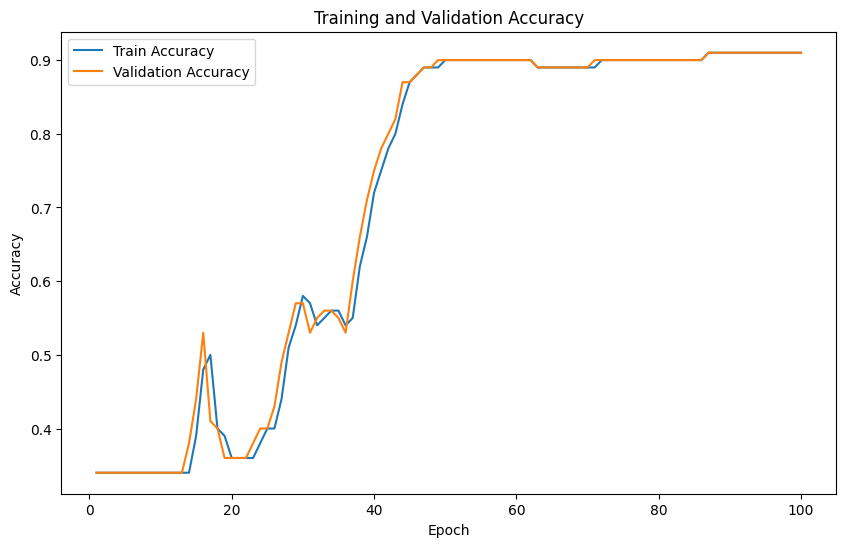

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Từ hình vẽ ta có thể thấy được rằng mode đã hội tụ khi epoch xấp xỉ 50 nên ta nên chọn trọng số để có thể dự đoán trên tập test với epoch=50 sẽ phù hợp và tối ưu nhất cho mô hình.

In [104]:
# Inference and Classification Report on Test Set
all_test_labels, all_test_preds = [], []

model = Net(input_dim, hidden_dim, output_dim).to(device)

selected_epoch = 50
model.load_state_dict(torch.load(f'weights_epoch_{selected_epoch}.pth'))

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)

        all_test_labels.extend(y.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())

# Generate classification report
print(classification_report(all_test_labels, all_test_preds, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        31
  versicolor       1.00      0.71      0.83        35
   virginica       0.77      1.00      0.87        34

    accuracy                           0.90       100
   macro avg       0.92      0.90      0.90       100
weighted avg       0.92      0.90      0.90       100



<ipython-input-104-4b2247bfd663>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights_epoch_{selected_epoch}.pth'))
